<a href="https://colab.research.google.com/github/JraHike76/DS-Unit-2-Applied-Modeling/blob/master/module3-permutation-boosting/Jay_Adamo_Permutation_Boosting_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [ ]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/JraHike76/Build-Week-Unit-2/master/Seattle_Air%20BnB_Reviews_2016.csv')

print(df.shape)

(3818, 20)


In [ ]:
df.columns


Index(['id', 'last_scraped', 'name', 'host_is_superhost', 'street',
       'neighbourhood_group_cleansed', 'location', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'square_feet', 'price', 'minimum_nights',
       'review_scores_rating', 'cancellation_policy'],
      dtype='object')

In [ ]:
# TARGET clean up
# will engineer a subset of the dataframe called 'highly_recommended' 
#    -based on percents from 'review_scores_rating'

df['highly_recommended'] = df['review_scores_rating'] >= 96

df['highly_recommended'].describe()

count      3818
unique        2
top       False
freq       2055
Name: highly_recommended, dtype: object

In [ ]:
# when previously looking for nulls they were not showing up and this may be due to 
#  the missing values being treated as False
#  this can also be seen in the previous cell's output
#  so I will drop all nulls from the highly_recommended subset and compare

# Dropping all nulls from subset

df = df.dropna(subset = ['review_scores_rating'])

df['highly_recommended'].describe()

count     3171
unique       2
top       True
freq      1763
Name: highly_recommended, dtype: object

In [ ]:
df.columns

Index(['id', 'last_scraped', 'name', 'host_is_superhost', 'street',
       'neighbourhood_group_cleansed', 'location', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'square_feet', 'price', 'minimum_nights',
       'review_scores_rating', 'cancellation_policy', 'highly_recommended'],
      dtype='object')

In [ ]:
# Now I can drop 'review_scores_rating' from the df with numpy
import numpy as np 

df = df.drop(['review_scores_rating'], axis=1)

# look at df with new column and 'review_scores_rating' dropped
df.head()

,id,last_scraped,name,host_is_superhost,street,neighbourhood_group_cleansed,location,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,square_feet,price,minimum_nights,cancellation_policy,highly_recommended
0,241032,2016-01-04,Stylish Queen Anne Apartment,f,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,"Seattle, WA",47.636289,-122.371025,Apartment,Entire home/apt,4,1.0,1.0,1.0,NaN,$85.00,1,moderate,False
1,953595,2016-01-04,Bright & Airy Queen Anne Apartment,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,"Seattle, WA",47.639123,-122.365666,Apartment,Entire home/apt,4,1.0,1.0,1.0,NaN,$150.00,2,strict,True
2,3308979,2016-01-04,New Modern House-Amazing water view,f,"West Lee Street, Seattle, WA 98119, United States",Queen Anne,"Seattle, WA",47.629724,-122.369483,House,Entire home/apt,11,4.5,5.0,7.0,NaN,$975.00,4,strict,True
4,278830,2016-01-04,Charming craftsman 3 bdm house,f,"14th Ave W, Seattle, WA 98119, United States",Queen Anne,"Seattle, WA",47.632918,-122.372471,House,Entire home/apt,6,2.0,3.0,3.0,NaN,$450.00,1,strict,False
5,5956968,2016-01-04,Private unit in a 1920s mansion,f,"West Comstock Street, Seattle, WA 98119, Unite...",Queen Anne,"Seattle, WA",47.630525,-122.366174,House,Private room,2,1.0,1.0,1.0,NaN,$120.00,1,strict,False


In [ ]:
# dropping superhost for now

# converting values from y and n to 1 and 0

# df['superhost'] = df['host_is_superhost'] 
# # creating a dict file  
# superhost = {'y': 1,'no': 0} 
  
# # applying to df 
# df.superhost = [superhost[item] for item in df.superhost] 
# print(data) 

# df['superhost']   

In [ ]:
# train/val/test split
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size = .20, random_state = 42)

train, val = train_test_split(train, test_size = .20, random_state = 42)

train.shape, val.shape, test.shape

((2028, 20), (508, 20), (635, 20))

In [ ]:
train.describe(include='number')

,id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,minimum_nights
count,2.028000e+03,2028.000000,2028.000000,2028.000000,2019.000000,2022.000000,2028.000000,51.000000,2028.000000
mean,5.088606e+06,47.628779,-122.332285,3.339744,1.258791,1.301187,1.717456,832.980392,2.071499
std,2.812194e+06,0.043153,0.031805,1.948386,0.590867,0.872239,1.117450,606.810168,1.957193
min,9.460000e+03,47.505088,-122.417219,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,2.748794e+06,47.608458,-122.353442,2.000000,1.000000,1.000000,1.000000,385.000000,1.000000
50%,5.391234e+06,47.623333,-122.328719,3.000000,1.000000,1.000000,1.000000,750.000000,2.000000
75%,7.511382e+06,47.662967,-122.309669,4.000000,1.000000,2.000000,2.000000,1200.000000,2.000000
max,1.024814e+07,47.733358,-122.254189,16.000000,8.000000,7.000000,10.000000,2600.000000,30.000000


In [ ]:
train.describe(exclude='number')

,last_scraped,name,host_is_superhost,street,neighbourhood_group_cleansed,location,property_type,room_type,price,cancellation_policy,highly_recommended
count,2028,2028,2028,2028,2028,2028,2028,2028,2028,2028,2028
unique,1,2023,2,1011,17,5,16,3,232,3,2
top,2016-01-04,Center UW Blast Internet New #102,f,"1st Avenue, Seattle, WA 98101, United States",Other neighborhoods,"Seattle, WA",House,Entire home/apt,$150.00,strict,True
freq,2028,2,1542,17,432,2023,944,1350,86,801,1146


In [ ]:
train.describe(include='all')

,id,last_scraped,name,host_is_superhost,street,neighbourhood_group_cleansed,location,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,square_feet,price,minimum_nights,cancellation_policy,highly_recommended
count,2.028000e+03,2028,2028,2028,2028,2028,2028,2028.000000,2028.000000,2028,2028,2028.000000,2019.000000,2022.000000,2028.000000,51.000000,2028,2028.000000,2028,2028
unique,NaN,1,2023,2,1011,17,5,NaN,NaN,16,3,NaN,NaN,NaN,NaN,NaN,232,NaN,3,2
top,NaN,2016-01-04,Center UW Blast Internet New #102,f,"1st Avenue, Seattle, WA 98101, United States",Other neighborhoods,"Seattle, WA",NaN,NaN,House,Entire home/apt,NaN,NaN,NaN,NaN,NaN,$150.00,NaN,strict,True
freq,NaN,2028,2,1542,17,432,2023,NaN,NaN,944,1350,NaN,NaN,NaN,NaN,NaN,86,NaN,801,1146
mean,5.088606e+06,NaN,NaN,NaN,NaN,NaN,NaN,47.628779,-122.332285,NaN,NaN,3.339744,1.258791,1.301187,1.717456,832.980392,NaN,2.071499,NaN,NaN
std,2.812194e+06,NaN,NaN,NaN,NaN,NaN,NaN,0.043153,0.031805,NaN,NaN,1.948386,0.590867,0.872239,1.117450,606.810168,NaN,1.957193,NaN,NaN
min,9.460000e+03,NaN,NaN,NaN,NaN,NaN,NaN,47.505088,-122.417219,NaN,NaN,1.000000,0.000000,0.000000,1.000000,0.000000,NaN,1.000000,NaN,NaN
25%,2.748794e+06,NaN,NaN,NaN,NaN,NaN,NaN,47.608458,-122.353442,NaN,NaN,2.000000,1.000000,1.000000,1.000000,385.000000,NaN,1.000000,NaN,NaN
50%,5.391234e+06,NaN,NaN,NaN,NaN,NaN,NaN,47.623333,-122.328719,NaN,NaN,3.000000,1.000000,1.000000,1.000000,750.000000,NaN,2.000000,NaN,NaN
75%,7.511382e+06,NaN,NaN,NaN,NaN,NaN,NaN,47.662967,-122.309669,NaN,NaN,4.000000,1.000000,2.000000,2.000000,1200.000000,NaN,2.000000,NaN,NaN


In [ ]:
#  This is a to do list in progress, i will make changes as needed



# ESTABLISHING FEATURES
# ______________________


# From the pandas profile in a previous notebook i gathered the following information:

# last_scraped has constant value "2016-01-04" =	Constant
# name has a high cardinality: 3153 distinct values	= High cardinality
# street has a high cardinality: 1306 distinct values	= High cardinality
# square_feet has 3080 (97.1%) missing values	= Missing
# minimum_nights is highly skewed (γ1 = 55.11203287)	= Skewed


# __________________________________________________________ 

# DROPPING:
# in addition to id, name, street, 'room_type', 'accommodates', 'bathrooms', 
# 'bedrooms','beds' latitude and longitude (these values will not be useful)
# i will be dropping review_scores_rating as it is no longer needed
# last_scraped has 1 unique identifier

# KEEPING:
# 'host_is_superhost', valuable, may change y and n to 1 and 0
# 'property_type', will change to room and home(whole house/apartment)
# 'cancellation_policy',important, only 3 values, maybe change to 1,2,3

# FURTHER EXPLORATION NEEDED: 
# 'minimum_nights', although skewed, this is valuable information when booking
# 'square_feet', 'price', possibly engineer price/sq ft, although missing information
#  price has a high cardinality: 260 distinct values, will keep for now


In [ ]:
# checking square feet,  will fix zeros
df['square_feet'].sort_values()

2246    0.0
2819    0.0
1547    0.0
2901    0.0
2953    0.0
       ... 
3809    NaN
3811    NaN
3812    NaN
3813    NaN
3814    NaN
Name: square_feet, Length: 3171, dtype: float64

In [ ]:
# checking location, not sure if I will keep this due to the special characters, okay for now
df['location'].value_counts()

Seattle, WA                  3164
Seattle , WA                    2
West Seattle, WA                2
Ballard, Seattle, WA            1
Phinney Ridge Seattle, WA       1
西雅图, WA                         1
Name: location, dtype: int64

In [ ]:
df['host_is_superhost'].value_counts()

f    2420
t     751
Name: host_is_superhost, dtype: int64

In [ ]:
df.columns

Index(['id', 'last_scraped', 'name', 'host_is_superhost', 'street',
       'neighbourhood_group_cleansed', 'location', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'square_feet', 'price', 'minimum_nights', 'cancellation_policy',
       'highly_recommended'],
      dtype='object')

In [ ]:
# # Target and features

target = 'highly_recommended'

# DROP/CHANGE COLUMNS to make features

# dropping column with 1 unique identifier
unique = df.drop(columns=['last_scraped'])

# dropping columns with randomness and variance
variance = df.drop(columns=['id', 'name', 'street', 'accommodates'])

# replace zeros with nulls
zeros = ['Square_feet']
for col in zeros:
  df[col] = df[col].replace(0, np.nan)

# engineer 


features = df.drop(columns=target)


In [ ]:
# Arrange data into X features matrix and y target vector

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[features]

X_train.shape, y_train.shape, y_test.shape, X_val.shape, y_val.shape, X_test.shape

ValueError: ignored

 * Fit a model. Does it beat your baseline?
 * Try xgboost.
 * Get your model's permutation importances.

In [ ]:
# Getting a baseline

df['highly_recommended'].value_counts(normalize=True)

True     0.555976
False    0.444024
Name: highly_recommended, dtype: float64

In [ ]:
!pip install category_encoders

In [ ]:
#pipeline for ordinal encoding with a Random Forest Classifier

import category_encoders as ce
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

# fit on train
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['last_scraped', 'name',
                                      'host_is_superhost', 'street',
                                      'neighbourhood_group_cleansed',
                                      'location', 'property_type', 'room_type',
                                      'price', 'cancellation_policy'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'last_scraped',
                                          'data_type': dtype('O'),
                                          'mapping':...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_

In [ ]:
print('Training Accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Training Accuracy: 1.0
Validation Accuracy: 0.6240157480314961


In [ ]:
# Prediction accuracy and recall score with validation 
#from random forest classifier
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix

rf_predict = pipeline.predict(X_val)

print("Accuracy Score:", accuracy_score(y_val, rf_predict))
print("Recall Score:", recall_score(y_val, rf_predict))

Accuracy Score: 0.6240157480314961
Recall Score: 0.7212543554006968


In [ ]:
from xgboost import XGBClassifier

xgb = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=100,
                  random_state=42,
                  n_jobs=-1)
)

xgb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['last_scraped', 'name',
                                      'host_is_superhost', 'street',
                                      'neighbourhood_group_cleansed',
                                      'location', 'property_type', 'room_type',
                                      'price', 'cancellation_policy'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'last_scraped',
                                          'data_type': dtype('O'),
                                          'mapping':...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_

In [ ]:
print('Training Accuracy:', xgb.score(X_train, y_train))
print('Validation Accuracy:', xgb.score(X_val, y_val))

Training Accuracy: 0.7810650887573964
Validation Accuracy: 0.6515748031496063


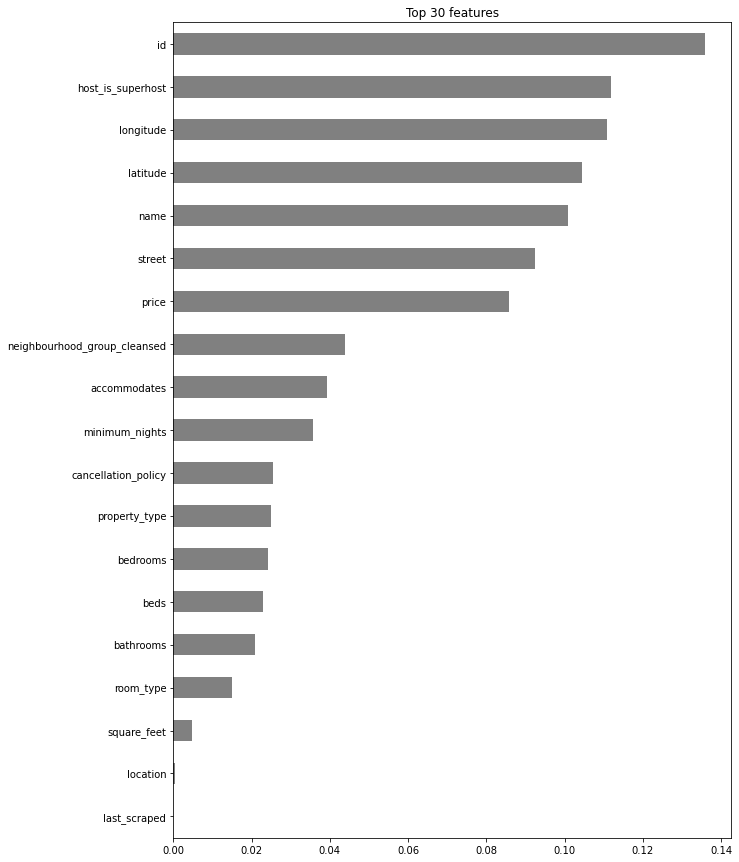

In [ ]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 30
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [ ]:
# Permutation Importances: Shuffle the values in a single column (one feature)
# OF YOUR VALIDATION SET
feature = 'cancellation_policy'
print(X_val[feature].head())
print()
print(X_val[feature].value_counts())

389       strict
769     moderate
1729    moderate
1664      strict
3771      strict
Name: cancellation_policy, dtype: object

strict      194
moderate    191
flexible    123
Name: cancellation_policy, dtype: int64


In [ ]:
import numpy as np

X_val_permuted = X_val.copy()
X_val_permuted[feature] = np.random.permutation(X_val_permuted[feature])

In [ ]:
acc = pipeline.score(X_val, y_val)
acc_permuted = pipeline.score(X_val_permuted, y_val)

print(f'Validation accuracy with {feature}:', acc)
print(f'Validation accuracy with {feature} permuted:', acc_permuted)
print(f'Permutation importance:', acc - acc_permuted)

Validation accuracy with cancellation_policy: 0.6240157480314961
Validation accuracy with cancellation_policy permuted: 0.6141732283464567
Permutation importance: 0.009842519685039353


In [ ]:
!pip install eli5

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

# Ignore warnings

transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)



feature_names = X_val.columns.tolist()

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.0606 ± 0.0345,host_is_superhost
0.0453 ± 0.0489,id
0.0134 ± 0.0162,latitude
0.0091 ± 0.0095,cancellation_policy
0.0079 ± 0.0201,street
0.0031 ± 0.0191,neighbourhood_group_cleansed
0.0012 ± 0.0088,bathrooms
0.0012 ± 0.0053,square_feet
0.0008 ± 0.0019,name
0 ± 0.0000,location
